In [8]:
import numpy as np
import random
import time
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cross_validation as cv
import sklearn.preprocessing
%matplotlib inline
tol = 10**(-10)

In [9]:
def kernel_expo(x,y,gamma):
    return np.exp(-gamma*(np.linalg.norm(x-y)**2))

In [10]:
def KKTviol(O,rho,mu,l,alpha,ens):
    ens2 = np.where(np.logical_or((rho-O[ens])*(1/(mu*l)-alpha[ens])>tol, (O[ens]-rho)*alpha[ens]>tol))
    if len(ens2[0]) == 0:
        return -1
    else :
        index = np.random.randint(len(ens2[0]))
        return ens[ens2[0][index]]

In [11]:
def argmax(O,i,ens):
    index = 0
    value = 0
    ens = list(ens)
    Oens = O[ens]
    return ens[np.argmax(O[i]-Oens)]

In [12]:
def optim(alpha,i,j,K,O,mu,l):
    delta = alpha[i]+alpha[j]
    Ci = O[i] - alpha[i]*K[i,i] -alpha[j]*K[i,j]
    Cj = O[j] - alpha[i]*K[i,j] -alpha[j]*K[j,j]
    # Condition droite (inutile dans le cas du noyau gaussien)
    if K[i,i]+K[j,j]-2*K[i,j] == 0:
        if Cj-Ci-K[i,i]>0:
            alphaj = max(0,delta-1/(l*mu))
            alphai = delta - alphaj
        elif Cj-Ci-K[i,i] <0:
            alphaj = min(1/(l*mu),delta)
            alphai = delta - alphaj
        else :
            alphaj = alpha[j]
            alphai = alpha[i]
    else:
        xmin =  (delta*(K[i,i]-K[i,j])+Ci-Cj)/( K[i,i]+K[j,j]-2*K[i,j])
        
        # condition si le min n'est pas atteint dans 0 1/(l*mu)
        # condition sur K inutile si noyau gaussien
        if K[i,i]+K[j,j]-2*K[i,j] < 0 or xmin <max(0,delta-1/(mu*l)) or xmin > min(1/(mu*l),delta):
            x0 = max(0,delta-1/(l*mu))
            fx0  = 1/2*(delta-x0)**2*K[i,i] + (delta-x0)*K[i,j] + 1/2*x0**2*K[j,j] + (delta-x0)*Ci + x0*Cj
            xmu = min(1/(l*mu),delta)
            fxmu  = 1/2*(delta-xmu)**2*K[i,i] + (delta-xmu)*K[i,j] + 1/2*xmu**2*K[j,j] + (delta-xmu)*Ci + xmu*Cj
            if fx0 > fxmu:
                alphaj = xmu
                alphai = delta - alphaj
            else :
                alphaj = x0
                alphai = delta - alphaj
        else :
            alphaj = xmin
            alphai = delta - alphaj

    alphai = delta - alphaj
    
    if alpha[i]+alpha[j] - (alphai + alphaj)>10**(-8):
        print("delta : ",alpha[i]+alpha[j], alphai + alphaj)
        print(alpha[i],alpha[j],alphai,alphaj)
    if alphai<0 or alphaj <0 or alphai >1/(mu*l) or alphaj >1/(mu*l):
        print("oups",alphai,alphaj)
    return alphai,alphaj
    

In [13]:
def SVcalc(alpha,c=1):
    SV = list(np.where(((alpha>tol) & (alpha<(c-tol))))[0])
    return SV

In [62]:
class osvm:
    def __init__(self,mu=0.01,maxiter=1000,maxiterii = 100,eps=0.001,gamma=5):
        assert mu>0,"mu doit être strictement positif"
        assert mu<=1,"mu doit être inférieur à 1"
        self.mu = mu
        self.eps = eps
        self.maxiter = maxiter
        self.maxiterii = maxiterii
        self.gamma = gamma
        self.len_sv = []
        self.rho_hist = []
        self.rho_var = []
        self.kkt_hist = []
        
    def fit(self,data):
        print("Initialisation")
        self.alpha = np.zeros(np.shape(data)[0])
        self.l = np.shape(data)[0] 
        l = self.l
        self.data = data
        K = np.array([[kernel_expo(x,y,self.gamma) for x in data] for y in data])
        choose = [i for i in range(l)]
        self.rho = 0
        s = 0
        while s <= 1-1/(l*self.mu):
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1/(l*self.mu)
            s += 1/(l*self.mu)
        if s != 1:
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1-s
            s = 1

        O = np.dot(self.alpha,K)
        self.rho = max(O[self.alpha>tol])
        self.rho_hist.append(self.rho)
        self.rho_var.append(np.var(max(O[self.alpha>tol])))

        print("Apprentissage")
        iter_etape = 0
        iteration = 0
        while iteration < self.maxiter:
            # Etape (i)
            enskkt = list(range(l))
            np.random.shuffle(enskkt)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,enskkt)
            iteration += 1
            if index == -1:
                print(iteration,"break index")
                break

            if iteration == 1 :
                SV = SVcalc(self.alpha)
            else:
                SV = SVcalc(self.alpha,1/(self.mu*l))
            
            while index in SV:
                    SV.remove(index)
            if SV == []:
                SV = SVcalc(self.alpha)
                while index in SV:
                    SV.remove(index)
            if SV ==[]:
                continue
            
            j = argmax(O,index,SV)
            alpha_index,alpha_j = self.alpha[index],self.alpha[j]
            self.alpha[index],self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
            if sum(self.alpha) > 1.001:
                print("etape i " ,sum(self.alpha))
                time.sleep(0.5)
            
            # update de rho
            O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
            O_actif = O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))]
            if len(O_actif)==0:
                self.rho = max(O[ (self.alpha>tol )]) 
            else:
                self.rho = np.mean(O_actif)

            self.rho_hist.append(self.rho)
            self.rho_var.append(np.var(O_actif))
            SV = SVcalc(self.alpha,1/(self.mu*l))
            
            # Etape (ii)
            np.random.shuffle(SV)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
            self.kkt_hist.append(len(np.where((self.rho-O[SV])*(1/(self.mu*l)-self.alpha[SV])>tol)[0])+ 
                                                            len(np.where((O[SV]-self.rho)*self.alpha[SV]>tol)[0]))
            iterii = 0
            while index !=-1 and len(SV)>=1 and iterii < self.maxiterii:
                iterii += 1
                while index in SV:
                    SV.remove(index)
                    
                if SV != []:
                    iter_etape += 1
                    j = argmax(O,index,SV)
                    Osv = O[index] - O
                    delta = self.alpha[index] + self.alpha[j]
                    alpha_index,alpha_j = self.alpha[index],self.alpha[j]
                    self.alpha[index] , self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)

                    O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
                    O_actif = O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))]
                    if len(O_actif) == 0:
                        self.rho = max(O[ (self.alpha>tol )]) 
                    else:
                        self.rho = np.mean(O_actif)
                    self.rho_hist.append(self.rho)
                    self.rho_var.append(np.var(O_actif))
                    self.O = O
                    self.K = K
                    SV = SVcalc(self.alpha,1/(self.mu*l))
                else:
                    continue
                    
                
                if len(SV) == 1:
                    print("len sv break")
                    break
                np.random.shuffle(SV)   
                index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
                self.kkt_hist.append(len(np.where((self.rho-O[SV])*(1/(self.mu*l)-self.alpha[SV])>tol)[0])+ 
                                                            len(np.where((O[SV]-self.rho)*self.alpha[SV]>tol)[0]))
                if index == -1:
                    break
                while index in SV:
                    SV.remove(index)
                
            if iteration%100 == 0 :
                print(iter_etape,iteration,self.maxiter,self.rho,np.dot(self.alpha,np.dot(self.alpha,K)))
                iter_etape = 0 
            
        # update rho
        O_actif = O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))]
        if len(O_actif) == 0:
            print("rho out")
            self.rho = max(O[ (self.alpha>tol )]) 
        else:
            self.rho = np.mean(O_actif)
    
    def predict(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.sign(np.dot(self.alpha,K)-self.rho)
    
    def decision_function(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.dot(self.alpha,K)-self.rho

# Apprentissage sur uniforme [-1;1]

In [22]:
data = 2*(-0.5 + np.random.rand(500))

In [23]:
test = osvm(mu=10**(-3),gamma = 1,maxiter=1000,maxiterii=50)
test.fit(data)

Initialisation
Apprentissage
4733 100 1000 0.483733403117 0.483733403081
5000 200 1000 0.483733403117 0.483733403081
5000 300 1000 0.483733403117 0.483733403081
5000 400 1000 0.483733403117 0.483733403081
5000 500 1000 0.483733403117 0.483733403081
5000 600 1000 0.483733403117 0.483733403081
5000 700 1000 0.483733403117 0.483733403081
5000 800 1000 0.483733403117 0.483733403081
5000 900 1000 0.483733403117 0.483733403081
5000 1000 1000 0.483733403117 0.483733403081


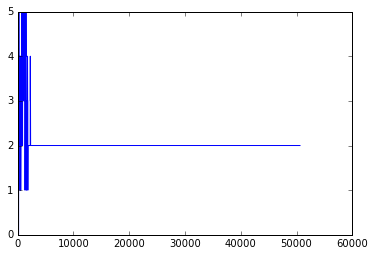

In [19]:
plt.plot(test.kkt_hist)

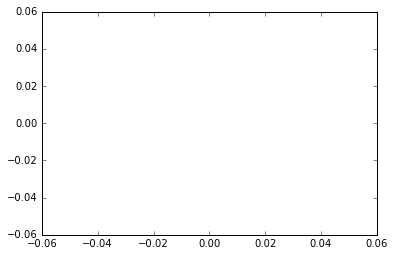

In [20]:
plt.plot(test.len_sv)
#plt.plot(test.lenOsv,'r')
plt.show()

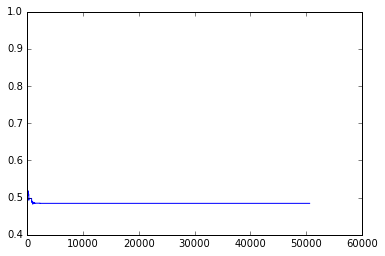

In [21]:
plt.plot(test.rho_hist)

In [13]:
test.alpha[test.alpha>0]

array([ 0.18073172,  0.40974696,  0.40952132])

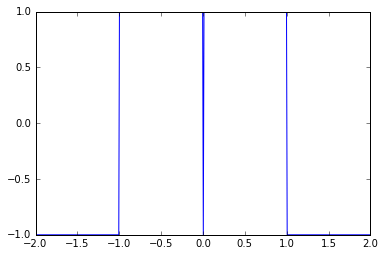

In [24]:
x=np.linspace(-2,2,500)
y = test.predict(x)
plt.plot(x,y)

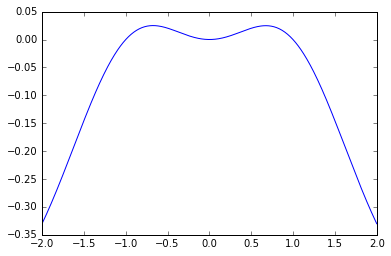

In [25]:
y = test.decision_function(x)
plt.plot(x,y)

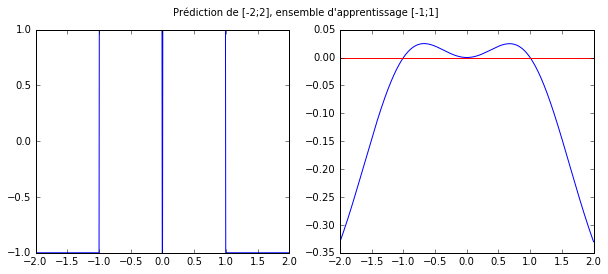

In [27]:
x=np.linspace(-2,2,1000)
#fig = plt.figure()
f, (ax1, ax2) = plt.subplots(1,2)
f.set_size_inches(10, 4)
ax1.plot(x,test.predict(x))
ax2.plot(x,test.decision_function(x))
ax2.plot(x,np.zeros((np.shape(x))),'r')
f.suptitle("Prédiction de [-2;2], ensemble d'apprentissage [-1;1]")
f.savefig("predict_microsoft.pdf",format = 'pdf')

In [16]:
xtest=np.linspace(-1,1,1000)

In [21]:
nb = sum(0.5*(1+test.predict(xtest)))
nbdata = sum(0.5*(1+test.predict(data)))
print(nb,nbdata)

993.0 498.0


# Apprentissage sur  uniforme $[-2,-1.7]^2 \cup [2,2.3]^2$

In [53]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = osvm(mu=0.07,gamma = 0.1,maxiter=2000,maxiterii=100)
clf.fit(X_train)


Initialisation
Apprentissage
1 100 2000 0.510824618897 0.499486660769
602 200 2000 0.493915754309 0.489155459909
1961 300 2000 0.485862295112 0.470441375183
0 400 2000 0.485862295112 0.470441375183
0 500 2000 0.485862295112 0.470441375183
0 600 2000 0.485862295112 0.470441375183
0 700 2000 0.485862295112 0.470441375183
0 800 2000 0.485862295112 0.470441375183
0 900 2000 0.485862295112 0.470441375183
0 1000 2000 0.485862295112 0.470441375183
0 1100 2000 0.485862295112 0.470441375183
0 1200 2000 0.485862295112 0.470441375183
0 1300 2000 0.485862295112 0.470441375183
0 1400 2000 0.485862295112 0.470441375183
0 1500 2000 0.485862295112 0.470441375183
0 1600 2000 0.485862295112 0.470441375183
0 1700 2000 0.485862295112 0.470441375183
0 1800 2000 0.485862295112 0.470441375183
0 1900 2000 0.485862295112 0.470441375183
0 2000 2000 0.485862295112 0.470441375183
rho out


In [54]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

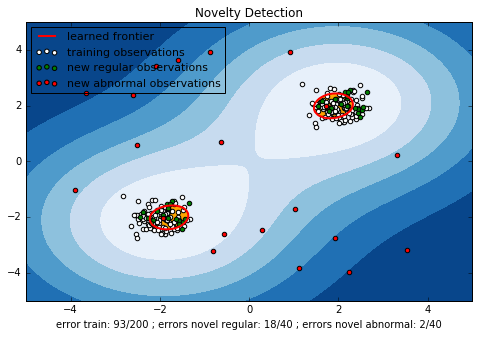

In [55]:
f = plt.figure()
f.set_size_inches(8, 5)
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))

plt.show()

In [56]:
f.savefig("predict_2d_microsoft_nu_faible.pdf",format = 'pdf')

# Test sur les données USPS

In [63]:
def load_usps(filename):
    with open(filename ,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)
datax,y = load_usps("usps.txt")
#plt.imshow(datax[1].reshape((16,16)),interpolation="nearest")

data_entier = [[] for i in range(10)]
for entier in range(10):
    data_entier[entier] = datax[ y == entier]

In [64]:
usps_osvm = osvm(mu=0.2,gamma = 1/(0.5*256),maxiter=3000,maxiterii=300)

In [65]:
data_train_6,data_test_6=cv.train_test_split(data_entier[6],test_size=0.3)
usps_osvm.fit(data_train_6)

Initialisation
Apprentissage
len sv break
len sv break
2 100 3000 0.328710409869 0.279770371634
len sv break
len sv break
546 200 3000 0.307859370908 0.263736615181
len sv break
len sv break
len sv break
len sv break
755 300 3000 0.310048644522 0.254919893992
17739 400 3000 0.308476445326 0.254404424567
18792 500 3000 0.303910316158 0.249639354139
len sv break
21552 600 3000 0.292326132096 0.246104547427
15673 700 3000 0.290031596393 0.243201689725
23985 800 3000 0.290218076687 0.242880310718
24239 900 3000 0.284263966827 0.237859706727
25917 1000 3000 0.27959544623 0.234951786364
15790 1100 3000 0.27771192939 0.234609341712
27900 1200 3000 0.274789236276 0.23417858983
28072 1300 3000 0.273157763163 0.23387314746
25510 1400 3000 0.269067681449 0.233166985692
24007 1500 3000 0.266447061416 0.232473831
18972 1600 3000 0.265542940338 0.231270610266
29191 1700 3000 0.26222497259 0.230598589567
12948 1800 3000 0.260476255555 0.229945387731
14293 1900 3000 0.255911734765 0.228791597808
19944

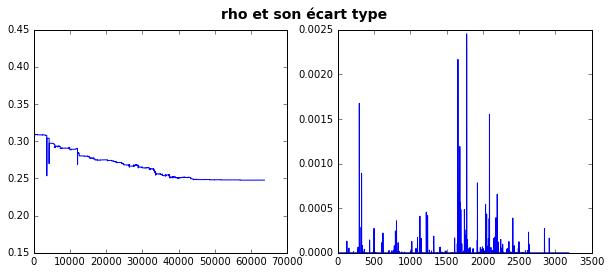

In [79]:
#fig = plt.figure()
f, (ax1, ax2) = plt.subplots(1,2)
f.set_size_inches(10, 4)
ax1.plot(usps_osvm.rho_hist[::10])
ax2.plot(np.sqrt(usps_osvm.rho_var[::200]))
f.suptitle("rho et son écart type",fontsize=14, fontweight='bold')
#f.savefig("rho.pdf",format = 'pdf')
#plt.plot(usps_osvm.rho_var)

In [68]:
is_6_a_6_test = sum(0.5*(1+usps_osvm.predict(data_test_6)))
print("Prediction sur l'ensemble test : ",is_6_a_6_test/len(data_test_6))

Prediction sur l'ensemble test :  0.54


In [69]:
is_9_a_6 = sum(0.5*(1+usps_osvm.predict(data_entier[9])))
is_6_a_6 = sum(0.5*(1+usps_osvm.predict(data_entier[6])))
print(is_9_a_6,is_6_a_6/len(data_entier[6]))

0.0 0.536144578313


##Plus précis ?

In [59]:
usps_osvm_precis = osvm(mu=0.000002,gamma = 1/(0.5*256),maxiter=1000,maxiterii=100)

In [60]:
usps_osvm_precis.fit(data_train_6)

Initialisation
Apprentissage
9800 100 1000 0.186744699465 0.186751282949
10000 200 1000 0.169090700908 0.169075600309
10000 300 1000 0.168149699463 0.168149641203
10000 400 1000 0.166282466314 0.166282665741
10000 500 1000 0.166036140962 0.16603613615
10000 600 1000 0.166022389032 0.16602237262
10000 700 1000 0.159980558679 0.159958416154
10000 800 1000 0.159835234274 0.159835234029
10000 900 1000 0.159817379898 0.159817372762
10000 1000 1000 0.159817386555 0.159817361865


In [22]:
is_6_a_6_test_precis = sum(0.5*(1+usps_osvm.predict(data_test_6)))
print("Prediction sur l'ensemble test:",is_6_a_6_test_precis/len(data_test_6))

is_9_a_6_precis = sum(0.5*(1+usps_osvm_precis.predict(data_entier[9])))
is_6_a_6_precis = sum(0.5*(1+usps_osvm_precis.predict(data_entier[6])))
print("Prediction sur la classe 9",is_9_a_6_precis, "Prediction sur l'ensemble de la classe 6",is_6_a_6_precis/len(data_entier[6]))

Prediction sur l'ensemble test: 0.82
Prediction sur la classe 9 0.0 Prediction sur l'ensemble de la classe 6 0.871987951807


## Test sur les troubles du rythme cardiaque

In [40]:
def load_cardiac(filename):
    with open(filename ,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f]
    tmp = np.array(data)
    return tmp[:,:-1],tmp[:,-1].astype(int)

data_card,y_card = load_cardiac("card_clean.txt")
data_card = sklearn.preprocessing.scale(data_card,axis=0)

In [41]:
data_card_ok = data_card[y_card == 1]
data_card_dead = data_card[y_card != 1]
data_card_train,data_card_test=cv.train_test_split(data_card_ok,test_size=0.2)

In [85]:
card_osvm = osvm(mu=0.03,gamma = 0.95*10**(-2),maxiter=1000,maxiterii=100)

In [86]:
card_osvm.fit(data_card_train)

Initialisation
Apprentissage
9835 100 1000 0.0428295610064 0.0428241930494
10000 200 1000 0.0330729666116 0.0330632201944
10000 300 1000 0.0303577092649 0.0303621204099
10000 400 1000 0.030257651186 0.0302576560725
10000 500 1000 0.0297699352189 0.0297699241792
10000 600 1000 0.029468884948 0.0294688801156
10000 700 1000 0.029468884948 0.0294688801156
10000 800 1000 0.029468884948 0.0294688801156
10000 900 1000 0.029468884948 0.0294688801156
10000 1000 1000 0.029468884948 0.0294688801156


In [87]:
print("Test données entrainement : ", sum(0.5*(1+card_osvm.predict(data_card_train)))/len(data_card_train))
print("Test données validation : ", sum(0.5*(1+card_osvm.predict(data_card_test)))/len(data_card_test))
print("Test données ok: ", sum(0.5*(1+card_osvm.predict(data_card_ok)))/len(data_card_ok))
print("Test données dead: ", sum(0.5*(1+card_osvm.predict(data_card_dead)))/len(data_card_dead))

Test données entrainement :  0.764102564103
Test données validation :  0.69387755102
Test données ok:  0.75
Test données dead:  0.281553398058


#Yahoo
http://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70

In [160]:
card_osvm.alpha

array([ 0.02326715,  0.        ,  0.        ,  0.02009537,  0.00625608,
        0.00828821,  0.0073981 ,  0.01432296,  0.        ,  0.01558495,
        0.0110989 ,  0.00745983,  0.00130038,  0.        ,  0.00488351,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00027705,
        0.00203914,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01635565,  0.01529841,  0.00440153,  0.01150863,  0.01187373,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00485726,  0.        ,  0.        ,  0.01971075,  0.        ,
        0.0016465 ,  0.        ,  0.        ,  0.        ,  0.00186744,
        0.014914  ,  0.        ,  0.        ,  0.01177404,  0.        ,
        0.02197333,  0.        ,  0.01835562,  0.        ,  0.        ,
        0.01026658,  0.        ,  0.        ,  0.01067953,  0.0037196 ,
        0.00983698,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01003382,  0.00851804,  0.01421792,  0.00142653,  0.00

# Hack

In [16]:
def load_hack(filename):
    with open(filename ,"r") as f:
        len_f = len(list(f))
        f.seek(0)
        len_line = len(f.readline().split(','))
        data = np.array([[0 for x in range(len_line)] for i in range(len_f)])
        dict_convert = [[] for i in range(len_line)]
        f.seek(0)
        for line in range(len_f):
            freadline = f.readline()
            spl = freadline .split(',')
            for elem in range(len_line):
                try:
                    data[line,elem] = float(spl[elem])
                except:
                    if spl[elem] in dict_convert[elem]:
                        getnb = dict_convert[elem].index(spl[elem])
                    else:
                        dict_convert[elem].append(spl[elem])
                        getnb = dict_convert[elem].index(spl[elem])
                    data[line,elem] = float(getnb)

    tmp = np.array(data)
    return tmp[:,:-1],tmp[:,-1].astype(int)

data_hack,y_hack = load_hack('hack')

In [22]:
data_hack_nm = sklearn.preprocessing.scale(data_hack,axis=0)

C:\Users\User\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [78]:
data_hack_ras = data_hack_nm[y_hack == 1][:2000]
data_hack_wip = data_hack_nm[y_hack != 1][:2000]
data_hack_train,data_hack_test=cv.train_test_split(data_hack_ras,test_size=0.5)

In [102]:
hack_osvm = osvm(mu=0.005,gamma =10**(-2),maxiter=1000,maxiterii=100)

In [103]:
hack_osvm.fit(data_hack_train)

Initialisation
Apprentissage
0 100 2000 0.864642706747 0.782694590759
0 200 2000 0.864642706747 0.782694590759
0 300 2000 0.864642706747 0.782694590759
81 400 2000 0.734249360301 0.671176489728
18 500 2000 0.734249379198 0.671176487711
5425 600 2000 0.734248363744 0.671176294372
10000 700 2000 0.733901276508 0.671101796791
669 800 2000 0.733753678748 0.67067456251
0 900 2000 0.733753678748 0.67067456251
0 1000 2000 0.733753678748 0.67067456251
0 1100 2000 0.733753678748 0.67067456251
0 1200 2000 0.733753678748 0.67067456251
0 1300 2000 0.733753678748 0.67067456251
0 1400 2000 0.733753678748 0.67067456251
0 1500 2000 0.733753678748 0.67067456251
0 1600 2000 0.733753678748 0.67067456251
0 1700 2000 0.733753678748 0.67067456251
0 1800 2000 0.733753678748 0.67067456251
0 1900 2000 0.733753678748 0.67067456251
0 2000 2000 0.733753678748 0.67067456251


In [104]:
print("Test données entrainement : ", sum(0.5*(1+hack_osvm.predict(data_hack_train)))/len(data_hack_train))
print("Test données validation : ", sum(0.5*(1+hack_osvm.predict(data_hack_test)))/len(data_hack_test))
print("Test données ok: ", sum(0.5*(1+hack_osvm.predict(data_hack_ras)))/len(data_hack_ras))
print("Test données dead: ", sum(0.5*(1+hack_osvm.predict(data_hack_wip)))/len(data_hack_wip))

Test données entrainement :  0.957
Test données validation :  0.962
Test données ok:  0.9595
Test données dead:  0.0405


#Breast cancer Winsconsin

In [22]:
def load_cancer_1(filename):
    with open(filename ,"r") as f:
        len_f = len(list(f))
        f.seek(0)
        len_line = len(f.readline().split(','))
        data = np.array([[0 for x in range(len_line)] for i in range(len_f)])
        dict_convert = [[] for i in range(len_line)]
        f.seek(0)
        for line in range(len_f):
            freadline = f.readline()
            spl = freadline .split(',')
            for elem in range(len_line):
                try:
                    data[line,elem] = float(spl[elem])
                except:
                    if spl[elem] in dict_convert[elem]:
                        getnb = dict_convert[elem].index(spl[elem])
                    else:
                        dict_convert[elem].append(spl[elem])
                        getnb = dict_convert[elem].index(spl[elem])
                    data[line,elem] = float(getnb)
    tmp = np.array(data)
    return tmp[:,1:-1],tmp[:,-1].astype(int)

data_cancer_1,y_cancer_1 = load_cancer_1('breast-cancer-wisconsin.data')

[[], [], [], [], [], [], ['?'], [], [], [], []]


In [25]:
data_cancer_1_ben = data_cancer_1[y_cancer_1 == 2]
data_cancer_1_mal = data_cancer_1[y_cancer_1 == 4]
data_cancer_1_train,data_cancer_1_test=cv.train_test_split(data_cancer_1_ben,test_size=0.2)

In [60]:
cancer_1_osvm = osvm(mu=0.05,gamma =10**(-2),maxiter=1500,maxiterii=300)
cancer_1_osvm.fit(data_cancer_1_train)

Initialisation
Apprentissage
len sv break
len sv break
len sv break
len sv break
38 100 1500 0.747995371369 0.612520071225
len sv break
len sv break
len sv break
len sv break
694 200 1500 0.625393538695 0.495566484566
len sv break
len sv break
len sv break
15603 300 1500 0.585833324003 0.46130704886
len sv break
15906 400 1500 0.610567181062 0.459482750829
len sv break
len sv break
9 500 1500 0.537592263821 0.428525517076
1951 600 1500 0.534937556373 0.428312455652
7663 700 1500 0.532963563242 0.427547255217
len sv break
len sv break
len sv break
len sv break
9192 800 1500 0.515004975541 0.419180552815
20564 900 1500 0.497040527319 0.415089881921
6095 1000 1500 0.478794240956 0.404995361842
len sv break
3523 1100 1500 0.474296150428 0.401857011035
0 1200 1500 0.474296150428 0.401857011035
0 1300 1500 0.474296150428 0.401857011035
0 1400 1500 0.474296150428 0.401857011035
0 1500 1500 0.474296150428 0.401857011035


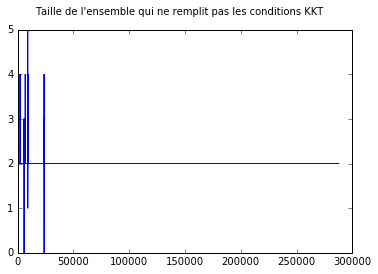

In [59]:
f = plt.figure()
f.suptitle("Taille de l'ensemble qui ne remplit pas les conditions KKT")
plt.plot(cancer_1_osvm.kkt_hist)
#f.savefig("kkt_viol.pdf",format = 'pdf')

In [61]:
print("Test données entrainement : ", sum(0.5*(1+cancer_1_osvm.predict(data_cancer_1_train)))/len(data_cancer_1_train))
print("Test données validation : ", sum(0.5*(1+cancer_1_osvm.predict(data_cancer_1_test)))/len(data_cancer_1_test))
print("Test données ok: ", sum(0.5*(1+cancer_1_osvm.predict(data_cancer_1_ben)))/len(data_cancer_1_ben))
print("Test données dead: ", sum(0.5*(1+cancer_1_osvm.predict(data_cancer_1_mal)))/len(data_cancer_1_mal))

Test données entrainement :  0.907103825137
Test données validation :  0.934782608696
Test données ok:  0.912663755459
Test données dead:  0.0290456431535
